Model: AlexNet

datasets:
- train count: 15k
- valid count: 6k
- test count: 9k

Accuracy: 87.6%

if we increase the dataset by 10x, the accuracy increases to 98.8%.
we can further increase the accuracy to 99.8% using 1M traning images.

In [83]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import os
import time
import json
import glob

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

tf.__version__

'2.10.0'

# Data Preview


In [84]:
# !python3 datasets/gen_captcha.py -d --npi=4 -n 6
# !python3 datasets/base.py ./images/char-4-epoch-6/

In [85]:
DATA_DIR = '/Users/bu/OneDrive/Generated'
H, W, C = 50, 200, 4      # height, width, 3(RGB channels)
N_LABELS = 256
D = 6 # num_per_image

In [86]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        label, _ = filename.split("_")
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [87]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.gif"))
attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['label', 'file']
df = df.dropna()
df.head()

,label,file
0,877761,/Users/bu/OneDrive/Generated/877761_a48e5e61-8...
1,871245,/Users/bu/OneDrive/Generated/871245_bd838809-6...
2,977292,/Users/bu/OneDrive/Generated/977292_f3007fd2-0...
3,931626,/Users/bu/OneDrive/Generated/931626_633638f1-1...
4,857148,/Users/bu/OneDrive/Generated/857148_0bed237c-5...


# Data Preprocessing

In [88]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.7)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 466, valid count: 200, test count: 286


In [89]:
from tensorflow.keras.utils import to_categorical
from PIL import Image


def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            im = Image.open(file)
#             im = im.resize((H, W))
            im = np.array(im) / 255.0
            images.append(np.array(im))
            labels.append(np.array([np.array(to_categorical(ord(i), N_LABELS)) for i in label]))
            if len(images) >= batch_size:
#                 print(np.array(images), np.array(labels))
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

# Model

In [90]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

input_layer = tf.keras.Input(shape=(H, W, C))
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

x = layers.Dense(D * N_LABELS, activation='softmax')(x)
x = layers.Reshape((D, N_LABELS))(x)

model = models.Model(inputs=input_layer, outputs=x)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 50, 200, 4)]      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 48, 198, 32)       1184      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 24, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 22, 97, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 11, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 9, 46, 64)         3692

# Training

In [91]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=5,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/5
7/7 [==============================] - 17s 2s/step - loss: 3.3569 - accuracy: 0.1328 - val_loss: 2.3900 - val_accuracy: 0.1415
Epoch 2/5
7/7 [==============================] - 7s 1s/step - loss: 2.2455 - accuracy: 0.1562 - val_loss: 2.2061 - val_accuracy: 0.1623
Epoch 3/5
7/7 [==============================] - 10s 2s/step - loss: 2.1118 - accuracy: 0.1589 - val_loss: 2.0645 - val_accuracy: 0.1484
Epoch 4/5
7/7 [==============================] - 7s 1s/step - loss: 2.0572 - accuracy: 0.1566 - val_loss: 2.0303 - val_accuracy: 0.1432
Epoch 5/5
7/7 [==============================] - 8s 1s/step - loss: 2.0140 - accuracy: 0.1667 - val_loss: 2.0241 - val_accuracy: 0.1554


# Result Analysis

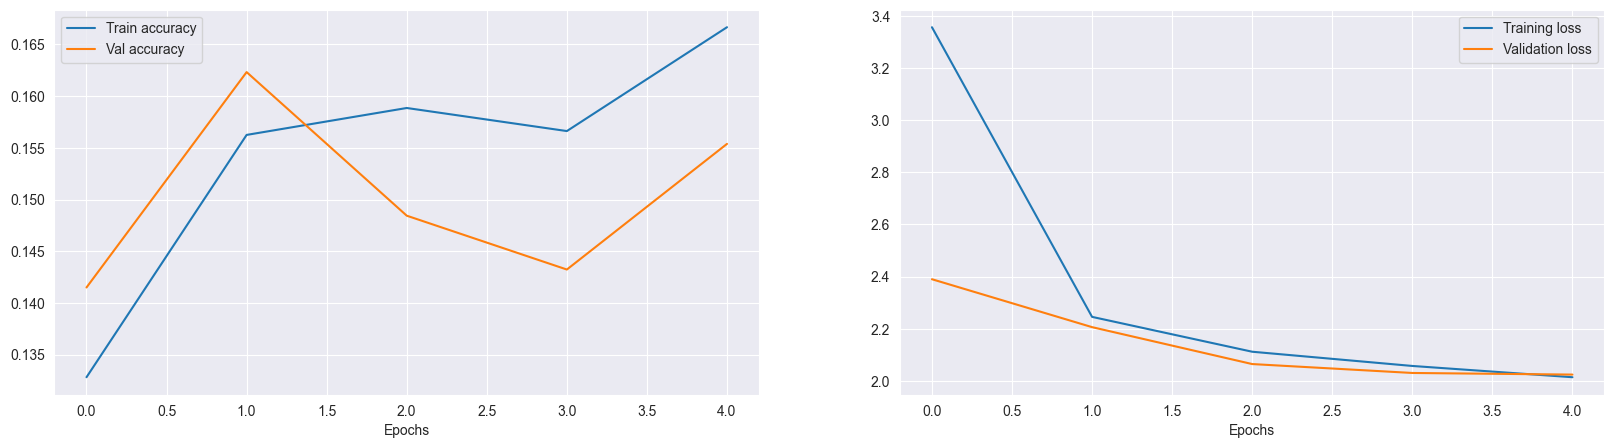

In [92]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)
plt.show()

In [93]:
# evaluate loss and accuracy in test dataset
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//128)))

2/2 [==============================] - 1s 507ms/step - loss: 2.0253 - accuracy: 0.1608


{'loss': 2.025256395339966, 'accuracy': 0.1608072966337204}

# Predict and display result

In [94]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_gen)

y_pred = model.predict_on_batch(x_test)

y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)

In [95]:
def format_y(y):
    return ''.join(map(lambda x: chr(int(x)), y))

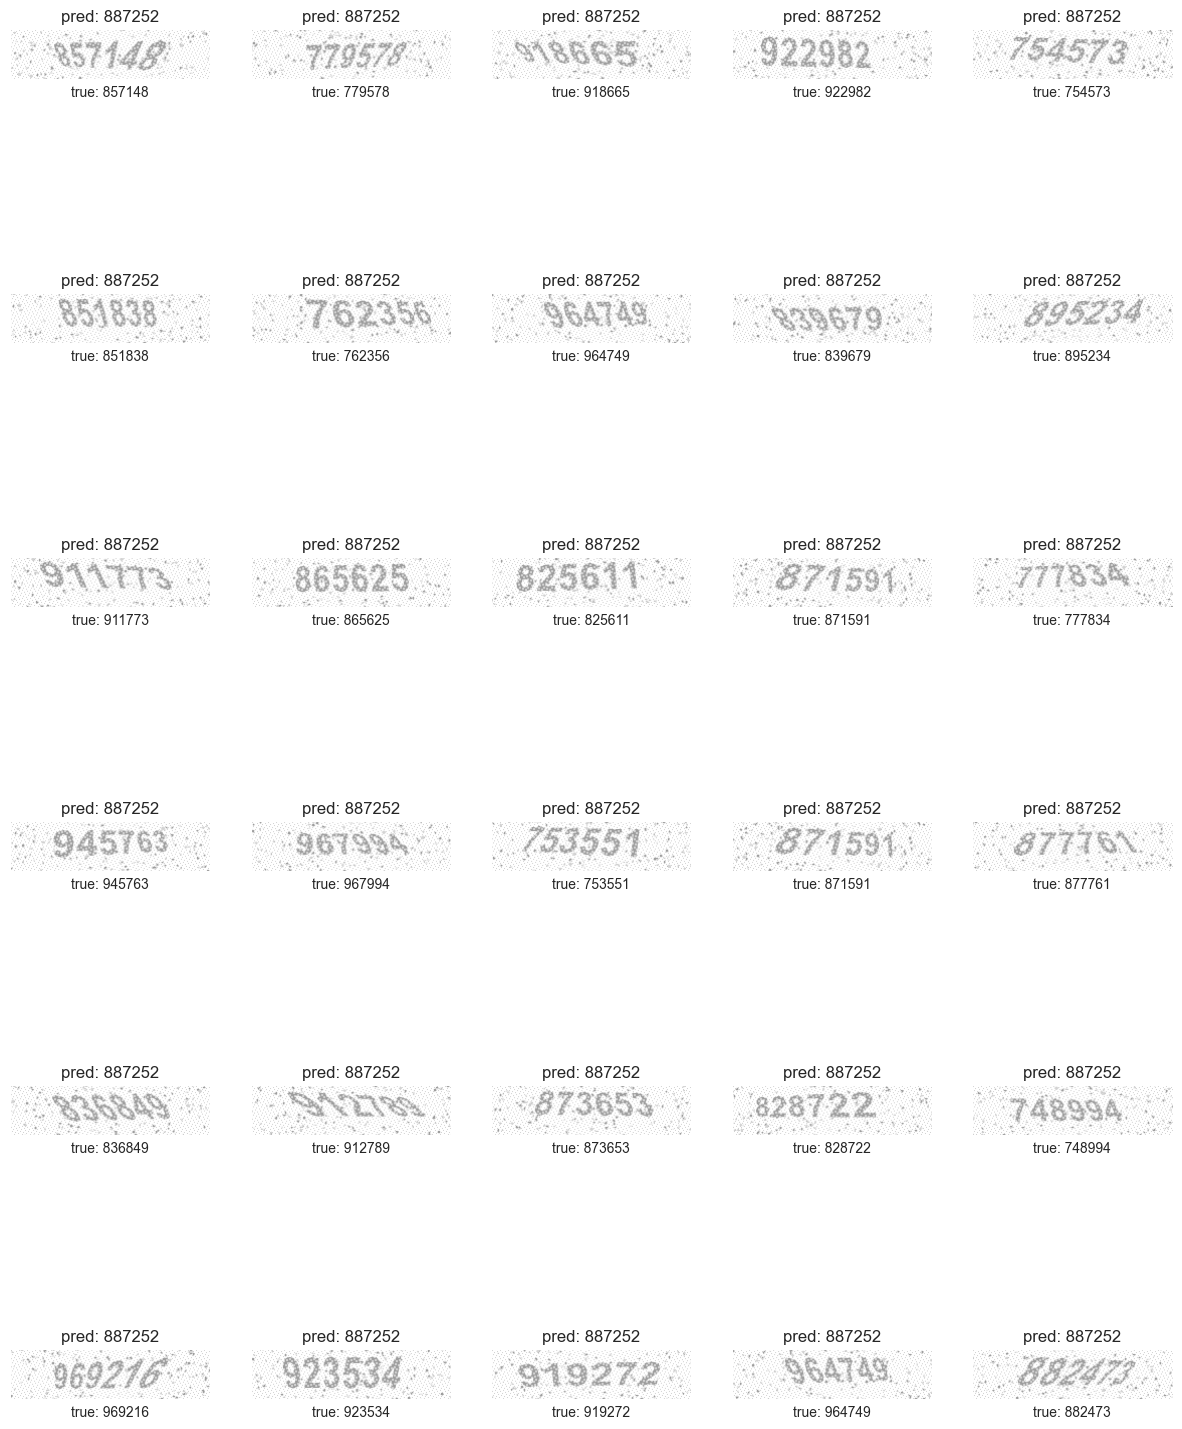

In [96]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('pred: %s' % format_y(y_pred[img_idx]))
    ax.set_xlabel('true: %s' % format_y(y_true[img_idx]))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()